# Language Identification and Similarity

In [1]:
from src.LIdentify import LIdentify, cmf_acc_matrix, plot_acc_cmf
from src.NgramModel import NGModel, tune_k, make_cmf
from src.Tokenizer import Tokenizer
from src.Normalizer import normalize_data
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from src.utils import *

In [2]:
# required files (change if needed)
af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

# Tri-gram Language Model

### Language Modelling

#### Text/Document Normalization

In [3]:
# Uncoment to normalize the data
# normalize_data(af_file, norm_af_file)
# normalize_data(en_file, norm_en_file)
# normalize_data(nl_file, norm_nl_file)
# normalize_data(xh_file, norm_xh_file)
# normalize_data(zu_file, norm_zu_file)

#### Define and Train a Tri-gram Language Model for Each Language

In [4]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [5]:
models = (en_model, af_model , nl_model, xh_model, zu_model)
val_files = (en_val_file, af_val_file, nl_val_file, xh_val_file, zu_val_file)

### Perplexity and Hyperparameter Tuning

#### Perplexity with the Laplace smoothing model (default k=1)

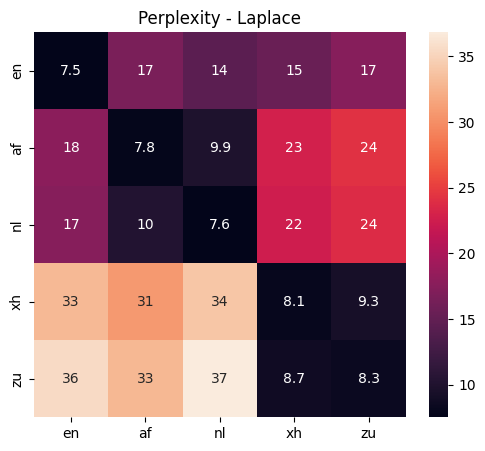

In [6]:
default_parameters = {
    model.name: {
        'k': 1,
    } for model in models
}
title = r"Perplexity - Laplace"
make_cmf(models, val_files, default_parameters, mode='add_k', title=title, save='report/figures/laplace.pdf')

In [7]:
k_list = np.arange(0.1, 1, 0.9 / 20)
perplexity_vals = {}
for model, file in zip(models, val_files):
    perplexity_vals[model.name] = tune_k(model, file, k_list)

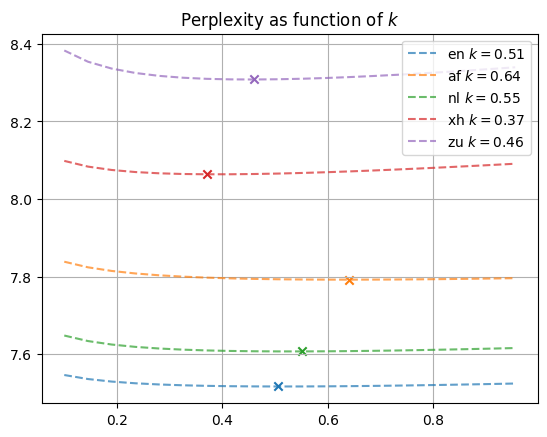

In [8]:
best_k = {}
for model, values in zip(models, perplexity_vals.values()):
    k = np.argmin(values)
    plt.plot(k_list, values, '--', label=fr"{model.name} $k = {k_list[k]:.2f}$", alpha=0.7)
    plt.scatter(k_list[k], values[k], marker='x')
    best_k[model.name] = k_list[k]
plt.title(r"Perplexity as function of $k$")
plt.grid()
plt.legend()
plt.show()

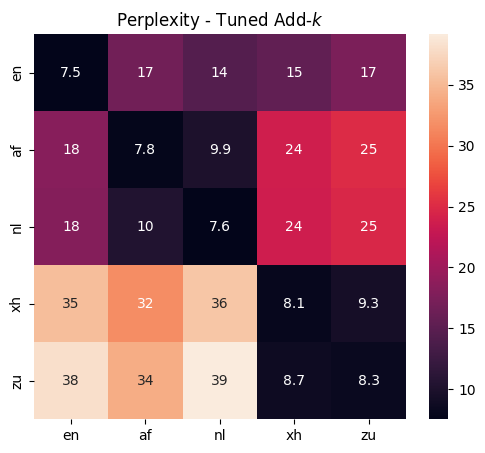

In [9]:
tuned_parameters = {
    model.name: {
        'k': best_k[model.name],
    } for model in models
}
title = r"Perplexity - Tuned Add-$k$"
make_cmf(models, val_files, tuned_parameters, mode='add_k', title=title, save="report/figures/add_k.pdf")

In [10]:
best_k

{'en': 0.5050000000000001,
 'af': 0.6400000000000001,
 'nl': 0.5500000000000002,
 'xh': 0.3700000000000001,
 'zu': 0.4600000000000001}

### Perplixity with Interpolation smoothing model

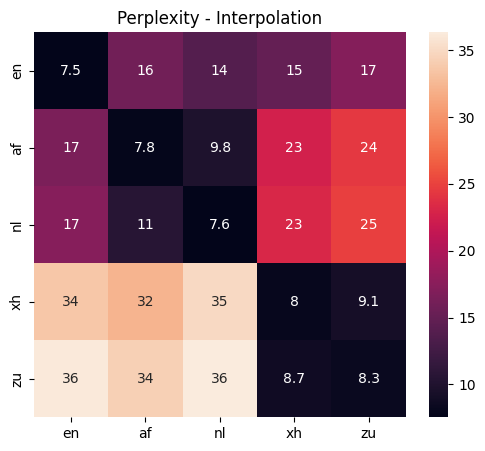

In [11]:
inter_parameters = {
    model.name: {
        'lambdas': [0.9, 0.075, 0.025],
    } for model in models
}
title = r"Perplexity - Interpolation"
make_cmf(models, val_files, inter_parameters, mode='inter', title=title, save='report/figures/inter.pdf')

#### English : tri-gram probability with (t,h) as history:

In [12]:
print("Add-alpha smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.around(en_model.prob(ngram, best_k['en']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Add-alpha smoothing
P(e|t,h) = 0.6801
P( |t,h) = 0.10159
P(a|t,h) = 0.08302
P(i|t,h) = 0.04469
P(o|t,h) = 0.03796
P(r|t,h) = 0.03386
P(n|t,h) = 0.00461
P(s|t,h) = 0.00333
P(>|t,h) = 0.00286
P(u|t,h) = 0.00239
P(y|t,h) = 0.00198
P(w|t,h) = 0.00071
P(d|t,h) = 0.00064
P(l|t,h) = 0.00057
P(m|t,h) = 0.00044
P(c|t,h) = 0.0003
P(t|t,h) = 0.00024
P(p|t,h) = 0.00017
P(f|t,h) = 0.0001
P(b|t,h) = 0.0001
P(h|t,h) = 3e-05
P(g|t,h) = 3e-05
P(0|t,h) = 3e-05
P(v|t,h) = 3e-05
P(<|t,h) = 3e-05
P(k|t,h) = 3e-05
P(x|t,h) = 3e-05
P(j|t,h) = 3e-05
P(z|t,h) = 3e-05
P(q|t,h) = 3e-05


In [13]:
print("Interpolation smoothing")
probs = defaultdict(float)
for char in en_model.vocab:
    ngram = ('t', 'h', char)
    key = f"P({char}|t,h)"
    val = np.round(en_model.probInt(ngram, inter_parameters['en']['lambdas']), 5)
    probs[key] = val
probs = sort_dict(probs)
for k, v in probs.items():
    print(f"{k} = {v}")

Interpolation smoothing
P(e|t,h) = 0.64956
P( |t,h) = 0.10421
P(a|t,h) = 0.08641
P(i|t,h) = 0.05225
P(o|t,h) = 0.04108
P(r|t,h) = 0.03354
P(n|t,h) = 0.00616
P(s|t,h) = 0.00456
P(u|t,h) = 0.0035
P(t|t,h) = 0.00311
P(>|t,h) = 0.00296
P(y|t,h) = 0.00293
P(l|t,h) = 0.00156
P(d|t,h) = 0.00137
P(w|t,h) = 0.00106
P(c|t,h) = 0.00105
P(m|t,h) = 0.00103
P(h|t,h) = 0.00094
P(p|t,h) = 0.00056
P(f|t,h) = 0.00051
P(g|t,h) = 0.00038
P(b|t,h) = 0.00038
P(0|t,h) = 0.0003
P(v|t,h) = 0.00021
P(<|t,h) = 0.00018
P(k|t,h) = 0.0001
P(x|t,h) = 4e-05
P(j|t,h) = 3e-05
P(z|t,h) = 2e-05
P(q|t,h) = 2e-05


### Text Generation

#### Add-$k$ smoothing models

In [14]:
for model in models:
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='', params={'k': best_k[model.name]}, mode='add_k')
    print(gen_text)
    pp = model.perplexity(gen_text, params={'k': best_k[model.name]}, doc=False, mode='add_k')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : en
<the the wristavithervy a peng i 0 0 bandifter whe bat ivions will so beciivers exa asin al reas win on as cand lan urrike auted gictied arieveread than s wil mocing moiders she cally>
Perplexity : 7.842242484724621
**********

Model : af
<diermod kom onde die van>
Perplexity : 6.218279795750197
**********

Model : nl
<het gen deze de poor op dien an evansta om voort hie co geverij derbouwer gerli ettsluctustahl eer sposse heeffebeldt de rek geookt>
Perplexity : 7.436193211319282
**********

Model : xh
<umethokumi kubikilalise adieshethu z>
Perplexity : 9.065636029466983
**********

Model : zu
<ngobhi irungo kuqalwe>
Perplexity : 7.500136717728601
**********



#### Interpolation smoothing model

In [15]:
for model in models:
    param = inter_parameters[model.name]
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='', params=param, mode='inter')
    print(gen_text)
    pp = model.perplexity(gen_text, params=param, doc=False, mode='inter')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : en
<whicomierion ally priffebricanimal atimingra supeethisto dectighown the anstic an>
Perplexity : 8.101445934778578
**********

Model : af
<hethy die geruistad vantwehie ber bie se moeid ingrof her dig en verste van beinwornaal wetly munig van zarik werie gebris prond>
Perplexity : 7.219535247640721
**********

Model : nl
<aat zijves een de in deeuw voek aanis ceschan mallen noximpundend nischtfoelde ing wor uit micheindpenemen vrionte uitiolog ingemaan de delegen hooordieset to bewer parbijn eerdan het lon ziorvan>
Perplexity : 7.322758235971932
**********

Model : xh
<i bu ka kisezanaye eqabatsikhi iche>
Perplexity : 11.222622167378837
**********

Model : zu
<nko ifulika nothiyini lulucabalalalidiandludhale 0 umu ic afripedi ukaza kantu banini abeni er izu ulelabesi abayogwe zona isho oby waha>
Perplexity : 7.903119336673515
**********



## Language Identification

In [16]:
labels = [model.name for model in models]
x, y = read_test('data/test.lid.txt')

### Add-$k$ model

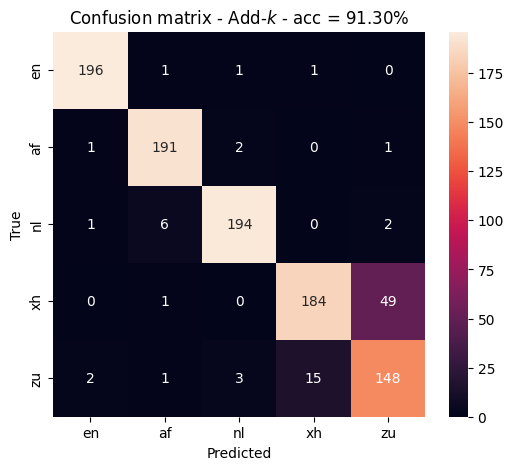

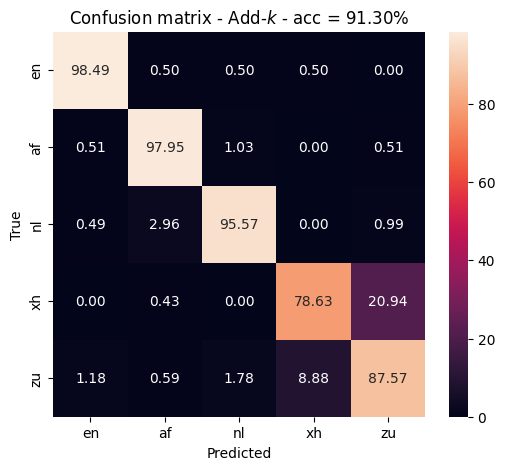

In [17]:
k_list2 = {k: {'k': v} for k, v in best_k.items()}
identifiers = LIdentify(models, mode='add_k', params=k_list2)

cmf = cmf_acc_matrix(identifiers, x, y)
accuracy = 100 * np.diag(cmf).sum() / cmf.sum()
cmf_norm = 100*cmf / cmf.sum(axis=1)[:, np.newaxis]

plot_acc_cmf(cmf, accuracy, labels, title=r'Add-$k$', fmt='.0f', save='report/figures/acc_lang.pdf')
plot_acc_cmf(cmf_norm, accuracy, labels, title=r'Add-$k$', fmt='.2f')
plt.show()

### Interpolation model

In [18]:
inter_parameters = {
    model.name: {
        'lambdas': [0.8, 0.15, 0.05],
    } for model in models
}

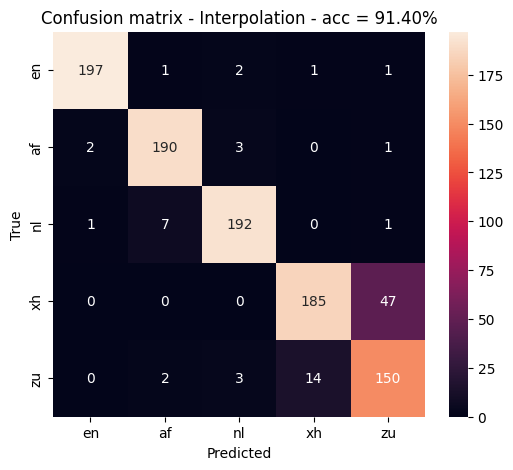

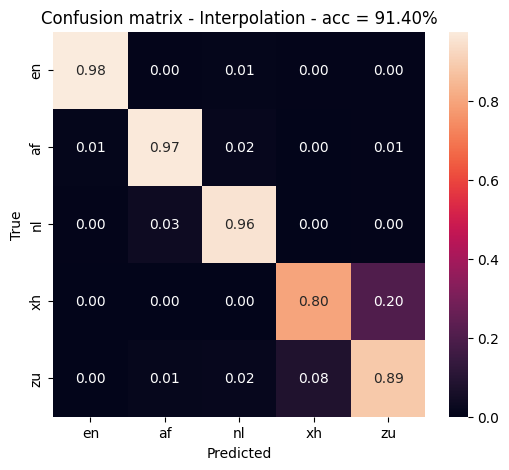

In [19]:
identifiers2 = LIdentify(models, mode='inter', params=inter_parameters)
cmf2 = cmf_acc_matrix(identifiers2, x, y)
accuracy2 = 100 * np.diag(cmf2).sum() / cmf2.sum()
cmf_norm2 = cmf2 / cmf2.sum(axis=1)[:, np.newaxis]


plot_acc_cmf(cmf2, accuracy2, labels, title=r'Interpolation', fmt='.0f')
plot_acc_cmf(cmf_norm2, accuracy2, labels, title=r'Interpolation', fmt='.2f')
plt.show()

# Byte-Pair Encoding for Language Similarity

In [20]:
from src.BytePairEncoding import BytePairEncoding, plot_intersection_cmf

## Byte-Pair Encoding (BPE)

In [21]:
languages = ('en', 'af', 'nl', 'xh', 'zu')
train_files = (norm_en_file, norm_af_file, norm_nl_file, norm_xh_file, norm_zu_file,)

In [22]:
bpes = {
    lang: BytePairEncoding(name=lang) for lang in languages
}

In [23]:
for file, lang in zip(train_files, bpes.keys()):
    bpes[lang].init(file)
    bpes[lang].learn(max_iter=100)

Token learning for: en
Encoding Done
Token learning for: af
Encoding Done
Token learning for: nl
Encoding Done
Token learning for: xh
Encoding Done
Token learning for: zu
Encoding Done


### Ten first merges for each language

In [24]:
for lang in languages:
    print(f"Language : {lang}")
    for i, merge in enumerate(bpes[lang].history[:10]):
        print(f"{i + 1:<2} Merge : {merge[0]}+{merge[1]} --> {merge[2]}")
    print("=" * 25)

Language : en
1  Merge : e+_ --> e_
2  Merge : s+_ --> s_
3  Merge : t+h --> th
4  Merge : d+_ --> d_
5  Merge : n+_ --> n_
6  Merge : e+r --> er
7  Merge : a+n --> an
8  Merge : t+_ --> t_
9  Merge : th+e_ --> the_
10 Merge : i+n --> in
Language : af
1  Merge : e+_ --> e_
2  Merge : n+_ --> n_
3  Merge : e+r --> er
4  Merge : i+e_ --> ie_
5  Merge : d+ie_ --> die_
6  Merge : s+_ --> s_
7  Merge : t+_ --> t_
8  Merge : 0+_ --> 0_
9  Merge : a+n --> an
10 Merge : e+l --> el
Language : nl
1  Merge : n+_ --> n_
2  Merge : e+_ --> e_
3  Merge : e+n_ --> en_
4  Merge : e+r --> er
5  Merge : t+_ --> t_
6  Merge : d+e_ --> de_
7  Merge : s+_ --> s_
8  Merge : a+a --> aa
9  Merge : 0+_ --> 0_
10 Merge : e+l --> el
Language : xh
1  Merge : a+_ --> a_
2  Merge : e+_ --> e_
3  Merge : i+_ --> i_
4  Merge : o+_ --> o_
5  Merge : a+n --> an
6  Merge : k+u --> ku
7  Merge : n+g --> ng
8  Merge : e+l --> el
9  Merge : i+n --> in
10 Merge : e+n --> en
Language : zu
1  Merge : a+_ --> a_
2  Merge : i+_

In [25]:
len(bpes['en'].vocab)

128

## Vocabulary intersection after 100 merge

In [26]:
intersection = np.zeros((5, 5))
for i, lang1 in enumerate(languages):
    for j, lang2 in enumerate(languages):
        vocab1 = bpes[lang1].vocab
        vocab2 = bpes[lang2].vocab
        intersection[i, j] = len(vocab1.intersection(vocab2))
percentage_intersection = (intersection / np.diag(intersection))*100

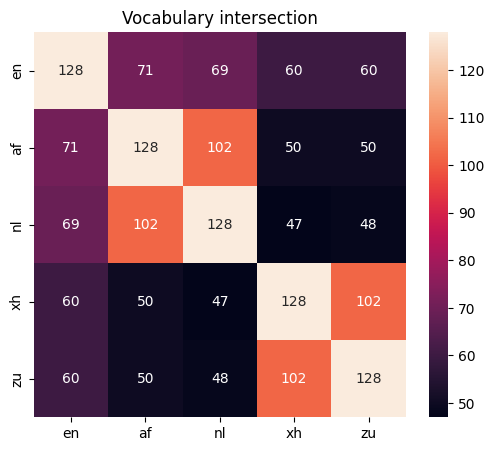

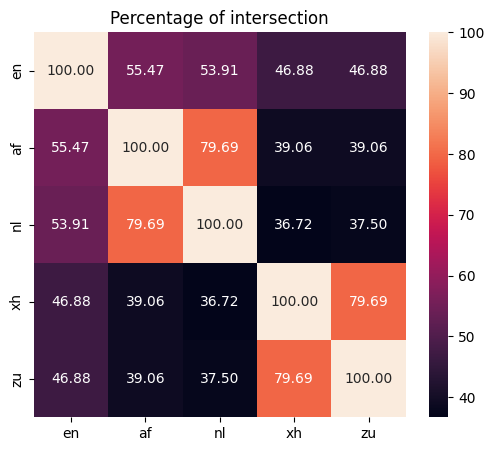

In [27]:
plot_intersection_cmf(intersection, languages, title="Vocabulary intersection", fmt='.0f')
plot_intersection_cmf(percentage_intersection, languages, title="Percentage of intersection", fmt='.2f', save='report/figures/intersection_cmf.pdf')

# References
* **Herman Kamper**, NLP817, https://www.kamperh.com/nlp817/, Stellenbosch University
* **Daniel Jurafsky, James H. Martin**, Speech and Language Processing, 3rd Edition, Stanford University, University of Colorado at Boulder
* **Compare Language** http://www.elinguistics.net/Compare_Languages.aspx
